In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from sklearn.preprocessing import LabelEncoder


In [2]:
training_data = pd.read_csv('data/twitter-entity-sentiment-analysis/twitter_training.csv')
validation_data = pd.read_csv('data/twitter-entity-sentiment-analysis/twitter_validation.csv')

In [3]:
training_data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


# Data Preprocessing

In [4]:
# add name or title to columns
training_data.columns = ['ID', 'Entity', 'Sentiment', 'Message']
validation_data.columns = ['ID', 'Entity', 'Sentiment', 'Message']

# fill null/nan values with empty string in the Message column
training_data['Message'] = training_data['Message'].astype(str).fillna('')
validation_data['Message'] = validation_data['Message'].astype(str).fillna('')

#### Explanatory data analysis
##### sentiment distribution

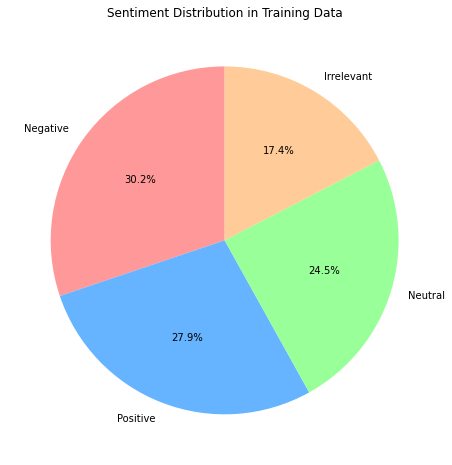

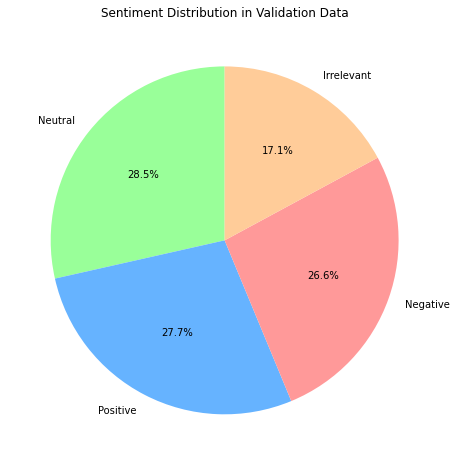

In [5]:
sentiment_counts = training_data['Sentiment'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title('Sentiment Distribution in Training Data')
plt.show()

sentiment_counts = validation_data['Sentiment'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#99ff99','#66b3ff','#ff9999','#ffcc99'])
plt.title('Sentiment Distribution in Validation Data')
plt.show()

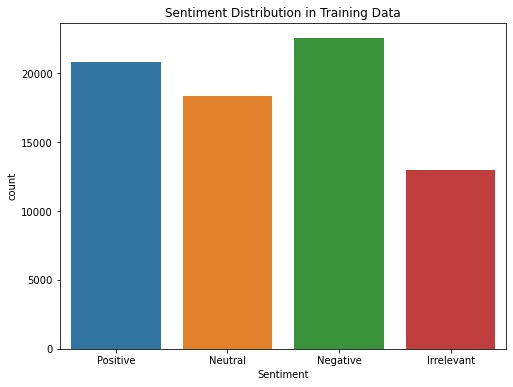

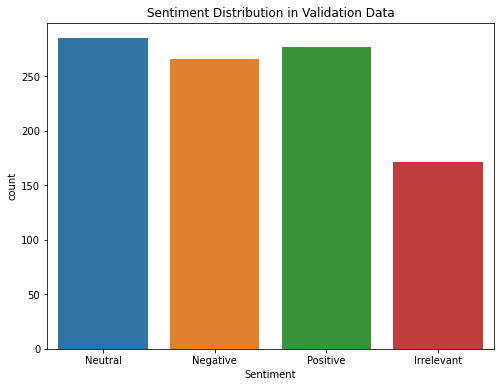

In [6]:
plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment', data=training_data)
plt.title("Sentiment Distribution in Training Data")
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=validation_data)
plt.title('Sentiment Distribution in Validation Data')
plt.show()

#### Frequency of All Entities in Training Data

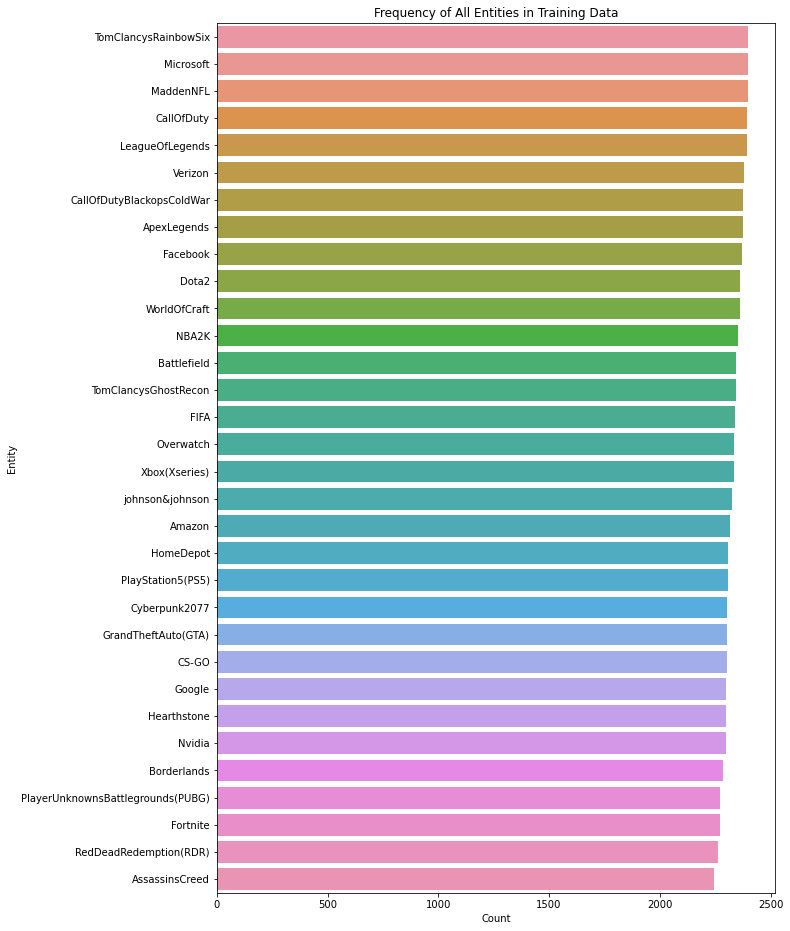

In [7]:
entity_counts = training_data['Entity'].value_counts()

plt.figure(figsize=(10, len(entity_counts) / 2))  
sns.barplot(y=entity_counts.index, x=entity_counts.values, orient='h')
plt.title('Frequency of All Entities in Training Data')
plt.xlabel('Count')
plt.ylabel('Entity')
plt.show()

#### Stacked Bar Chart of Sentiment Distribution by Entity

<Figure size 864x576 with 0 Axes>

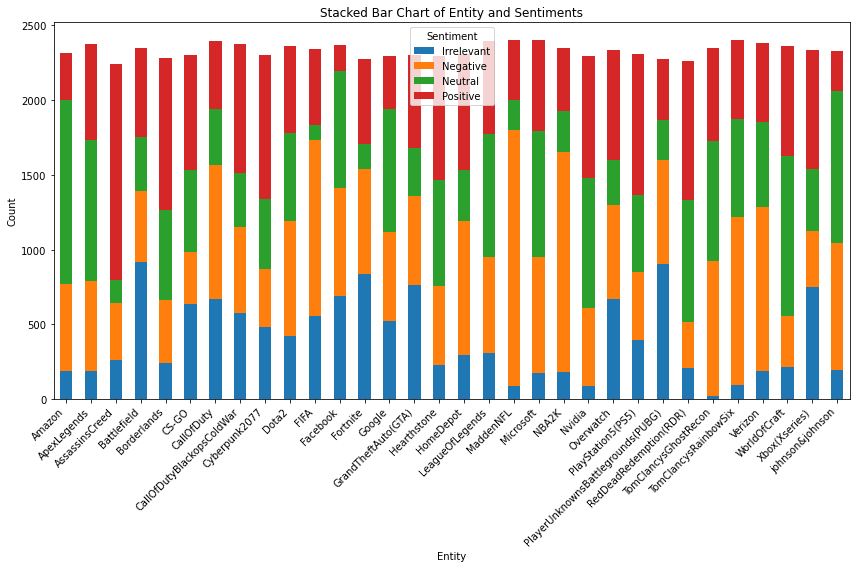

In [8]:
entity_sentiment_counts = pd.crosstab(training_data['Entity'], training_data['Sentiment'])

plt.figure(figsize=(12, 8))
entity_sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Stacked Bar Chart of Entity and Sentiments')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Message Length Distribution

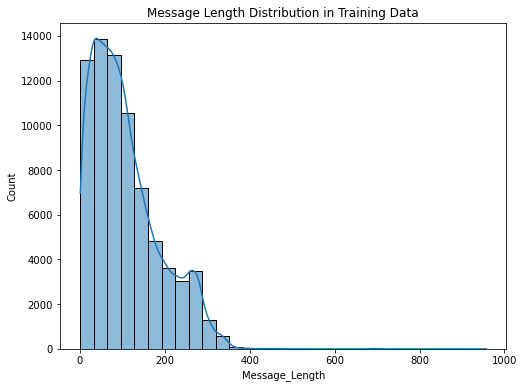

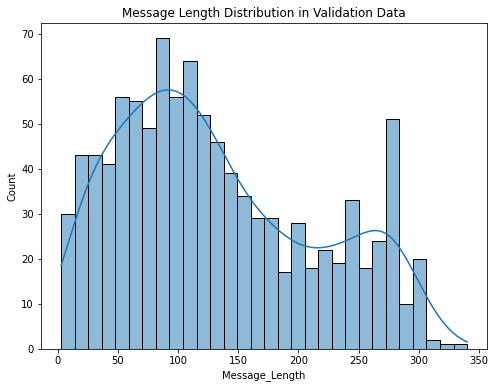

In [9]:
training_data['Message_Length'] = training_data['Message'].apply(len)
validation_data['Message_Length'] = validation_data['Message'].apply(len)

plt.figure(figsize=(8, 6))
sns.histplot(training_data['Message_Length'], kde=True, bins=30)
plt.title('Message Length Distribution in Training Data')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(validation_data['Message_Length'], kde=True, bins=30)
plt.title('Message Length Distribution in Validation Data')
plt.show()

#### Preprocess the text using TF-IDF

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(training_data['Message'])
X_validation_tfidf = tfidf_vectorizer.transform(validation_data['Message'])


In [11]:
y_train = training_data['Sentiment']
y_validation = validation_data['Sentiment']

# Classification

#### k-Means++ clustering

In [38]:
wcss = []
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_train_tfidf)
    wcss.append(kmeans.inertia_)

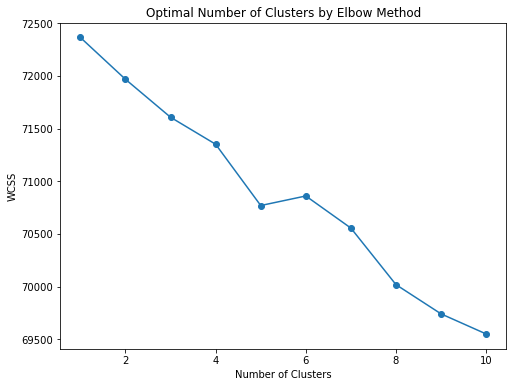

In [39]:
# Plot the WCSS for determining optimal number of clusters 
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Optimal Number of Clusters by Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [40]:
# Initialize the KMeans model and train it
kmeans_model = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans_model.fit(X_train_tfidf)
# Predict cluster labels for the validation set
cluster_labels = kmeans_model.predict(X_train_tfidf)

#### Logistic Regression

In [44]:
lr_model = LogisticRegression(max_iter=1000)

# Train the model
lr_model.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_pred_lr = lr_model.predict(X_validation_tfidf)

# Classification Report
accuracy_lr = accuracy_score(y_validation, y_pred_lr)
report_lr = classification_report(y_validation, y_pred_lr)
print("Logistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression Classification Report:\n", report_lr)

Logistic Regression Accuracy: 0.8168168168168168
Logistic Regression Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.82      0.73      0.77       171
    Negative       0.79      0.88      0.83       266
     Neutral       0.86      0.77      0.81       285
    Positive       0.80      0.86      0.83       277

    accuracy                           0.82       999
   macro avg       0.82      0.81      0.81       999
weighted avg       0.82      0.82      0.82       999



#### Random Forest

In [42]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth= 100, random_state=42)

# Train the model
rf_model.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_pred_rf = rf_model.predict(X_validation_tfidf)

# Classification Report
accuracy_rf = accuracy_score(y_validation, y_pred_rf)
report_rf = classification_report(y_validation, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Classification Report:\n", report_rf)

Random Forest Accuracy: 0.938938938938939
Random Forest Classification Report:
               precision    recall  f1-score   support

  Irrelevant       1.00      0.88      0.94       171
    Negative       0.95      0.96      0.95       266
     Neutral       0.91      0.94      0.93       285
    Positive       0.92      0.95      0.94       277

    accuracy                           0.94       999
   macro avg       0.95      0.93      0.94       999
weighted avg       0.94      0.94      0.94       999



### Decision Tree

In [45]:
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_pred_dt = dt_model.predict(X_validation_tfidf)

# Evaluate the model
accuracy_dt = accuracy_score(y_validation, y_pred_dt)
report_dt = classification_report(y_validation, y_pred_dt)

# Classification Report 
print("Decision Tree Model Accuracy:", accuracy_dt)
print("Decision Tree Model Classification Report:\n", report_dt)

Decision Tree Model Accuracy: 0.8868868868868869
Decision Tree Model Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.91      0.82      0.87       171
    Negative       0.90      0.95      0.92       266
     Neutral       0.87      0.86      0.86       285
    Positive       0.88      0.90      0.89       277

    accuracy                           0.89       999
   macro avg       0.89      0.88      0.88       999
weighted avg       0.89      0.89      0.89       999



#### ANN

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import copy
import torch.optim as optim

In [13]:
# Encode Sentiments into numerical values
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_validation_encoded = encoder.transform(y_validation)

In [14]:
n_classes=len(np.unique(y_train_encoded))
y_train_categorical  = nn.functional.one_hot(torch.from_numpy(y_train_encoded).to(torch.int64), num_classes=n_classes)
y_validation_categorical  = nn.functional.one_hot(torch.from_numpy(y_validation_encoded).to(torch.int64), num_classes=n_classes)

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(X_train_tfidf.shape[1], 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, n_classes),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().cuda()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)


In [16]:
class NumpyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = torch.from_numpy(data)
        self.targets = torch.from_numpy(targets)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]      
        return sample, target

train_dataset = NumpyDataset(X_train_tfidf.toarray(),y_train_encoded)
validation_dataset = NumpyDataset(X_validation_tfidf.toarray(),y_validation_encoded)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=64,shuffle=False)

In [17]:
train_losses = []
train_counter = []
criterion = nn.CrossEntropyLoss()

def train(epoch, network, optimizer):
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  network.train()
  for batch_idx, (data, target) in enumerate(train_dataloader):
    data, target = data.float().cuda(), target.cuda()
    # import pdb; pdb.set_trace()
    optimizer.zero_grad()
    output = network(data)
    loss = criterion(output, target)#F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # if batch_idx % log_interval == 0:
  train_losses.append(loss.item())
  train_counter.append((batch_idx*64) + ((epoch-1)*len(train_dataloader.dataset)))


  print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
    epoch, batch_idx * len(data), len(train_dataloader.dataset),
    100. * batch_idx / len(train_dataloader), loss.item()))

classes = ['0','1','2','3']#,'4','5','6','7','8','9']
testdb_losses = []
test_losses = []
def test(network_inp):
  test_counter = [i*len(validation_dataloader.dataset) for i in range(n_epochs + 1)]
  class_correct = list(0. for i in range(n_classes))
  class_total = list(0. for i in range(n_classes))

  network_inp.eval()
  test_loss = 0
  correct_cnt = 0
  with torch.no_grad():
    for data, target in validation_dataloader:
      data,target = data.float().cuda(), target.cuda()
      output = network_inp(data)
      test_loss += criterion(output, target).item()#F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      # import pdb; pdb.set_trace()
      correct_cnt += pred.eq(target.data.view_as(pred)).sum()
      correct_tensor = pred.eq(target.data.view_as(pred))
      # correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
      correct = np.squeeze(correct_tensor.cpu().numpy())
      # calculate test accuracy for each object class
      # import pdb; pdb.set_trace()
      for i in range(len(target)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
          
  
  test_loss /= len(validation_dataloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  test_loss, correct_cnt, len(validation_dataloader.dataset), 100. * correct_cnt / len(validation_dataloader.dataset)))

  
  for i in range(n_classes):
      if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [102]:
network = copy.deepcopy(model)
optimizer = optim.Adam(network.parameters(), lr=0.001)#, momentum=momentum)

n_epochs = 10
for epoch in range(1, n_epochs + 1):
  train(epoch, network, optimizer)
test(network)

Train Epoch: 1 [58325/74681 (100%)]	Loss: 0.284860
Train Epoch: 2 [58325/74681 (100%)]	Loss: 0.276948
Train Epoch: 3 [58325/74681 (100%)]	Loss: 0.130607
Train Epoch: 4 [58325/74681 (100%)]	Loss: 0.128459
Train Epoch: 5 [58325/74681 (100%)]	Loss: 0.165097
Train Epoch: 6 [58325/74681 (100%)]	Loss: 0.196883
Train Epoch: 7 [58325/74681 (100%)]	Loss: 0.041506
Train Epoch: 8 [58325/74681 (100%)]	Loss: 0.033477
Train Epoch: 9 [58325/74681 (100%)]	Loss: 0.066571
Train Epoch: 10 [58325/74681 (100%)]	Loss: 0.079610

Test set: Avg. loss: 0.0025, Accuracy: 973/999 (97%)



In [116]:
test(network)
# n_classes


Test set: Avg. loss: 0.0025, Accuracy: 973/999 (97%)

Test Accuracy of     0: 97% (166/171)
Test Accuracy of     1: 97% (260/266)
Test Accuracy of     2: 97% (277/285)
Test Accuracy of     3: 97% (270/277)

Test Accuracy (Overall): 97% (973/999)
